In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd 


def load_data():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter=',' 
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(file_path_labels, delimiter=delimiter, header=0, quotechar='"')
    return df_data, df_labels 

def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data


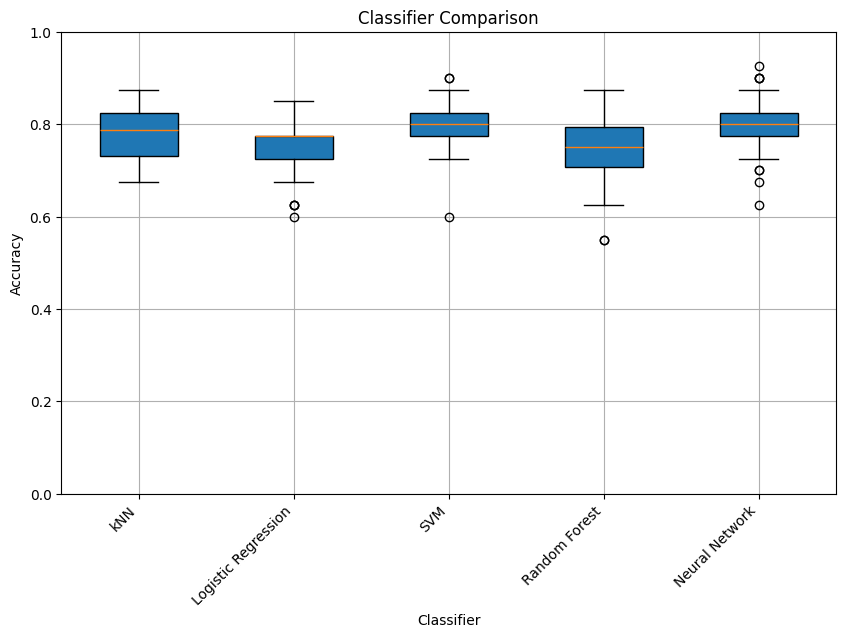

In [39]:
#Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? 
#Compare at least 5 classifiers of different character.

classifiers = {
    'kNN': KNeighborsClassifier(n_neighbors=11),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

data, labels = load_data()  

results = {}
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    X_train_scaled, X_test_scaled = standardize(X_train.values, X_test.values)
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train.values.ravel())
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        if name not in results.keys():
            results[name] = []
        results[name].append(accuracy)

# Create DataFrame for box plot
df = pd.DataFrame(results.items(), columns=['Classifier', 'Accuracy'])

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(df['Accuracy'], patch_artist=True)
plt.xticks([i+1 for i in range(len(df))], df['Classifier'], rotation=45, ha='right')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Comparison')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

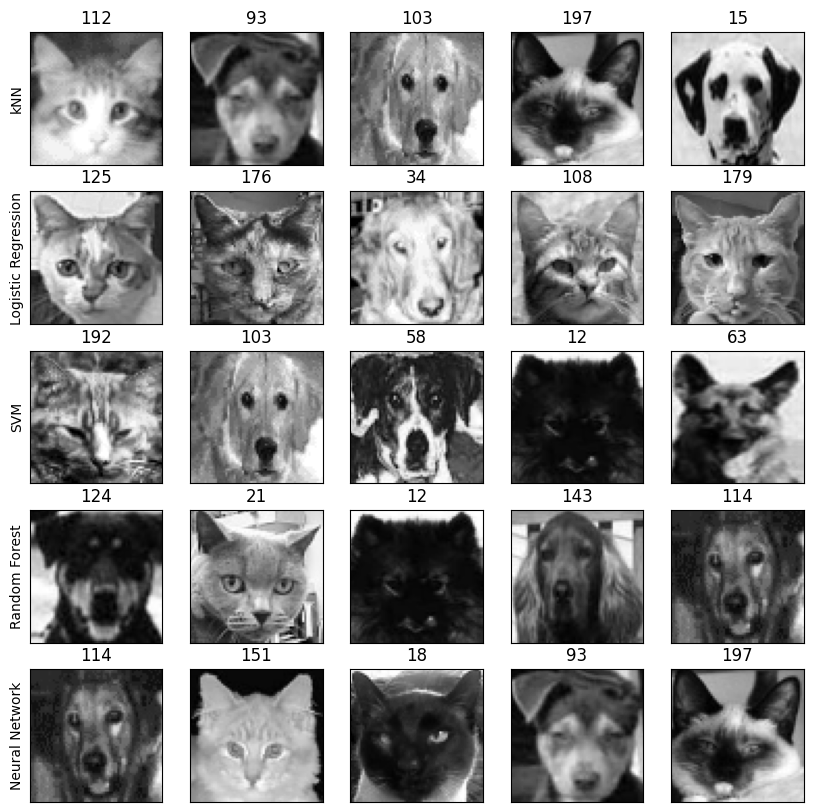

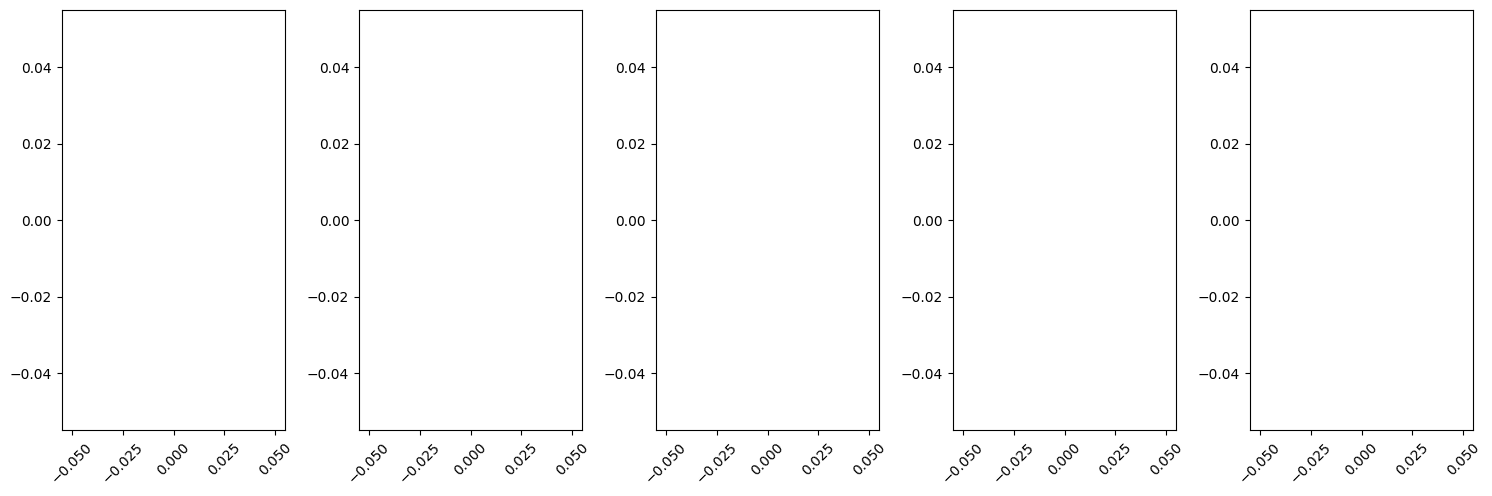

In [42]:
#Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? 
#Why do you think these are difficult images to classify? Do the classifiers struggle with the same observations? 

#Are the errors balanced or is one class more difficult to classify correctly?
from collections import Counter

data, labels = load_data()

results = {}
for _ in range(1):
    for name, clf in classifiers.items():
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
        X_train_scaled, X_test_scaled = standardize(X_train, X_test)

        clf.fit(X_train_scaled, y_train.values.ravel())
        y_pred = clf.predict(X_test_scaled)

        wrong_indices_pred = np.where(y_pred != y_test.values.ravel())[0]

        wrong_indices = y_test.iloc[wrong_indices_pred, 0].index.tolist()

        if name not in results:
            results[name] = []
        results[name].extend(wrong_indices)

fig1, axes1 = plt.subplots(5, 5, figsize=(10, 10))
fig2, axes2 = plt.subplots(1, 5, figsize=(15, 5))

for i, key in enumerate(results.keys()): 
    ax = axes2[i]
    count = np.bincount(results[key]) 
    lab = np.where(count > 20)[0] 
    str_lab = str_list = [str(i) for i in lab]
    ax.bar(str_lab, count[lab])
    ax.tick_params(axis='x', rotation=45)

    axes1[i][0].set_ylabel(f'{key}')
    element_counts = Counter(results[key])
    top_five = element_counts.most_common(5)
    for j, (ind, count) in enumerate(top_five):
        ax = axes1[i, j]
        ax.set_title(f'{ind}')
        ax.imshow(data.values[ind, :].reshape(64, 64).T, cmap='gray')  
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.show()


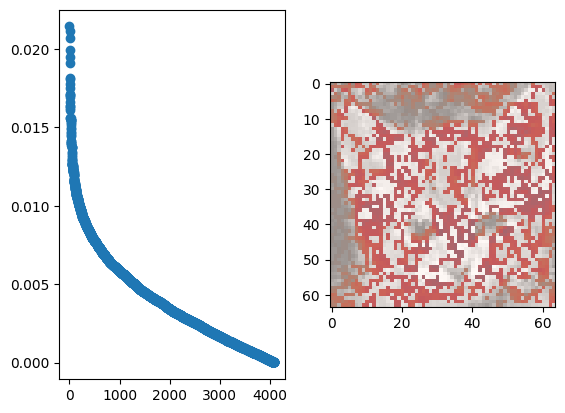

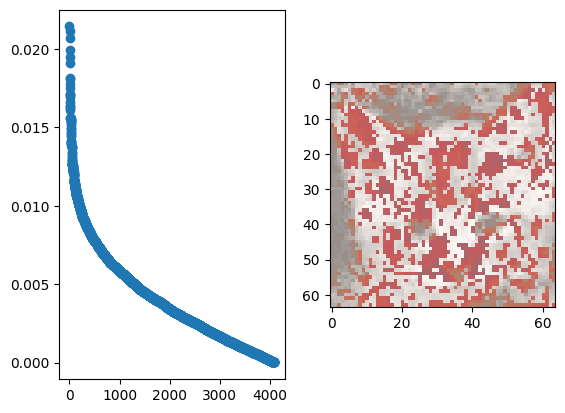

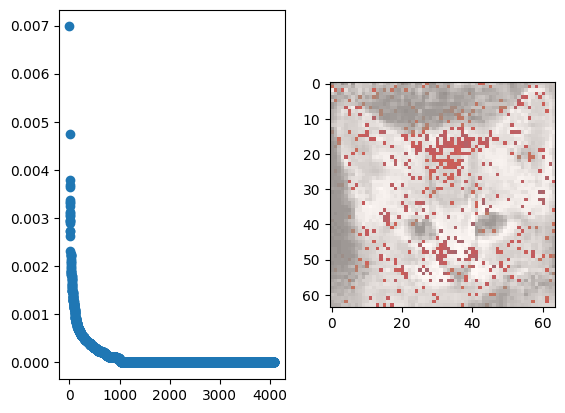

In [81]:
from sklearn.feature_selection import SelectFromModel
#Identify the most important pixels for classification - are these easy to identify or is there uncertainty in 
#the selection of important features? Compare at least 3 methods for selecting/identifying features. 
#Note, does not need to be the same methods as in 1a. Can you think of a way to improve on the stability of selection/identification? 
#(Of course, here you should explore methods other than feature importance in RF and GBM since you already did that for project 2).

#Can you explain why these pixels are selected/are deemed important?
#Do the identified predictive features differ between the classification methods?

# examine coefficients for logistic regression, support vectors for SVM,

######### SVM ##############
svm = SVC(kernel='linear')
svm.fit(X_train_scaled, y_train.values.ravel())

# Identify important features using SVM coefficients
svm_coefs = svm.coef_
abs_coefs = np.abs(svm_coefs)
important_features = np.argsort(abs_coefs)[::-1]

#print("Indices of important features:", len(important_features[0]))

plt.subplot(1,2,1)
abs_coefs[0].sort()
plt.plot(abs_coefs[0][::-1], 'o')
plt.subplot(1,2,2)
image = data.values[0, :]
image_reduced = np.zeros_like(image)
image_reduced[important_features[0][:2000]] = image[important_features[0][:2000]]
plt.imshow(image.reshape(64, 64).T, cmap='gray')
plt.imshow(image_reduced.reshape(64, 64).T, cmap='Reds', alpha=0.6)  # Use alpha to control transparency
plt.show()

############# LR #############
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_scaled, y_train.values.ravel())

# Use the model to select important features
feature_selector = SelectFromModel(lr_model, threshold='mean')  # Select features based on their importance
feature_selector.fit(X_train_scaled, y_train.values.ravel())

# Get selected features
important_features = np.where(feature_selector.get_support())[0]

plt.subplot(1,2,1)
abs_coefs[0].sort()
plt.plot(abs_coefs[0][::-1], 'o')
plt.subplot(1,2,2)
image = data.values[0, :]
image_reduced = np.zeros_like(image)
image_reduced[important_features] = image[important_features]
plt.imshow(image.reshape(64, 64).T, cmap='gray')
plt.imshow(image_reduced.reshape(64, 64).T, cmap='Reds', alpha=0.6)  # Use alpha to control transparency
plt.show()


############ RF ################
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train.values.ravel())

# Extract feature importance from tree splits
feature_importance = np.zeros(data.shape[1])
for tree in rf.estimators_:
    tree_feature_importance = tree.tree_.compute_feature_importances(normalize=False)
    feature_importance += tree_feature_importance

# Normalize feature importance across trees
feature_importance /= len(rf.estimators_)
important_features = np.argsort(feature_importance)[::-1]


plt.subplot(1,2,1)
feature_importance.sort()
plt.plot(feature_importance[::-1], 'o')
plt.subplot(1,2,2)
image = data.values[0, :]
image_reduced = np.zeros_like(image)
image_reduced[important_features[:500]] = image[important_features[:500]]
plt.imshow(image.reshape(64, 64).T, cmap='gray')
plt.imshow(image_reduced.reshape(64, 64).T, cmap='Reds', alpha=0.6)  # Use alpha to control transparency
plt.show()



In [91]:
#Cluster the data set. Do the clusters agree with the class labels? Does changing the number of clusters 
#have an impact on the overlap with the class labels?
#What characteristics of the data does the clustering pick up?
#Please think carefully about how you go about this question - how do you choose your input 
#(e.g. do you perform preprocessing or not) to the clustering algorithm? what method and settings? 
#Is it as clear cut how to make these choices if you didn't know the labels?